In [0]:
from google.colab import drive
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, average_precision_score, roc_auc_score

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [15]:
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Change this to the path where this folder is located in your Drive
os.chdir('/content/drive/My Drive/MLHC/data/')

Input paths

In [0]:
train_images_filepath = './train_images'
train_labels_filepath = './train_labels'
test_images_filepath = './test_images'
rotated_test_images_filepath = './test_images_randomly_rotated'

im_height = 256
im_width = 256

Helper functions

In [0]:
def load_data(train_images_filepath, train_labels_filepath, size, offset):
  X = np.zeros((50, im_height, im_width, 1), dtype=np.float32)
  y = np.zeros((50, im_height, im_width, 1), dtype=np.float32)
  images = []
  labels = []
  for i in range(size):
    x_img = np.load(train_images_filepath + '/sample-'+str(i + offset) +'.npy')
    y_img = np.load(train_labels_filepath + '/sample-'+str(i + offset) +'.npy')
    images.append(x_img)
    labels.append(y_img)
    x_img = resize(x_img, (im_height, im_width, 1), mode = 'constant', preserve_range = True)
    y_img = resize(y_img, (im_height, im_width, 1), mode = 'constant', preserve_range = True)
    X[i] = x_img/255.0
    y[i] = y_img/255.0
  return X, y, images, labels

In [0]:
def plot_random_sample(size, train, test):
  for i in range(size):
    fig = plt.figure(figsize=(8, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(train[i][i, :, :])
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(test[i][i, :, :])
    plt.axis('off')
    plt.show()

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size):
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'valid')(input_tensor)
    x = Activation('relu')(x)
    
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    x = Activation('relu')(x)
    return x
  
def get_unet(input_img, n_filters = 64, dropout = 0.1):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3)
    
    outputs = Conv2D(filters=3, kernel_size=(1, 1), activation='softmax')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

Load the data into an array of images and an array of resized images 

In [0]:
X, y, train_images, train_labels = load_data(train_images_filepath, train_labels_filepath, 50, 0)

In [0]:
X_test, X_rotated_test, test_images, test_rotated_images = load_data(test_images_filepath, rotated_test_images_filepath, 10, 50)

Plot random samples from train and test set

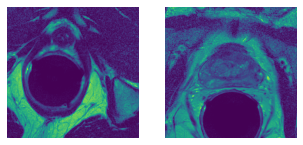

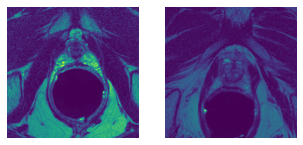

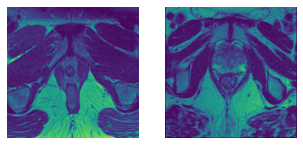

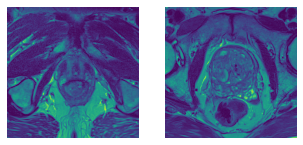

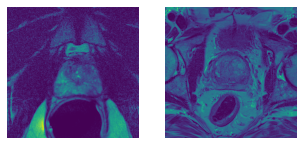

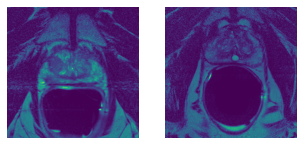

In [49]:
plot_random_sample(6, train_images, test_images)

Plot random samples of image label pairs

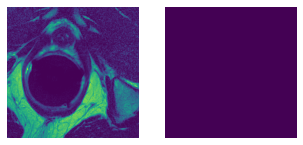

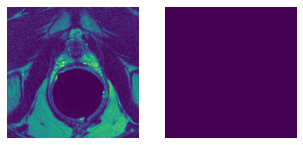

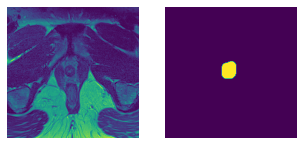

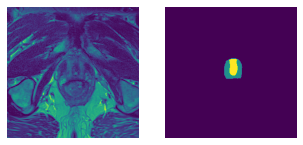

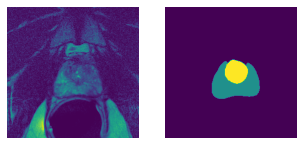

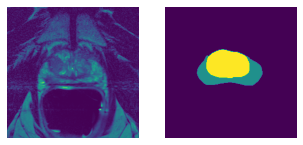

In [48]:
plot_random_sample(6, train_images, train_labels)

Create an instance of Keras ImageDataGenerator for the images and the masks

In [0]:
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

Fit the data generator to the two data arrays

In [0]:
image_datagen.fit(X)
mask_datagen.fit(y)

# Retrieve and plot one batch of images

For the training images

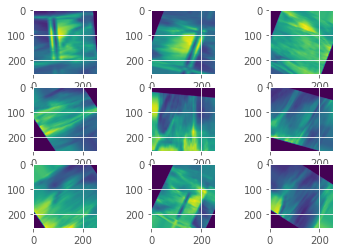

In [79]:
for X_batch, y_batch in image_datagen.flow(X, y, batch_size=9):
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i].reshape(256, 256))
	plt.show()
	break

For the masks 

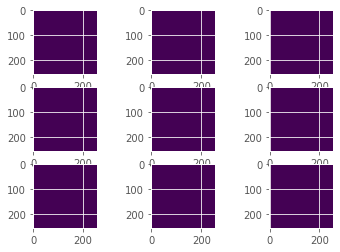

In [92]:
for X_batch, y_batch in mask_datagen.flow(y, X, batch_size=9):
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i].reshape(256, 256))
	plt.show()
	break

In [0]:
image_generator = image_datagen.flow(X,y)
mask_generator = mask_datagen.flow(y,X)

In [0]:
train_generator = zip(image_generator, mask_generator)

Split the training data into training and validation data

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

Create the Unet model

In [0]:
input_img = Input((256, 256, 1), name='img')
model = get_unet(input_img, dropout=0.05)
model.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

Create callbacks for the model

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ModelCheckpoint('unet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    TensorBoard(log_dir='logs', write_graph=True)
]

Train the model with the augmented data

In [0]:
model.fit_generator(
    train_generator,
    steps_per_epoch=2000,
    epochs=50,
    workers=8)

Train the model with the regular data

In [101]:
results = model.fit(X_train, y_train, batch_size=32, epochs=10, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))


Train on 45 samples, validate on 5 samples
Epoch 1/10
45/45 [==============================] - 131s 3s/step - loss: 2.3842e-07 - accuracy: 1.0000 - val_loss: 2.3842e-07 - val_accuracy: 1.0000

Epoch 00001: val_loss improved from 0.00000 to 0.00000, saving model to unet.h5
Epoch 2/10
45/45 [==============================] - 132s 3s/step - loss: 2.3842e-07 - accuracy: 1.0000 - val_loss: 2.3842e-07 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/10
45/45 [==============================] - 131s 3s/step - loss: 2.3842e-07 - accuracy: 1.0000 - val_loss: 2.3842e-07 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/10
45/45 [==============================] - 132s 3s/step - loss: 2.3842e-07 - accuracy: 1.0000 - val_loss: 2.3842e-07 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/10
45/45 [==============================] - 131s 3s/step - loss: 2.3842e-07 - accuracy: 1.0000 - val_loss: 2.3842e-0

In [29]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 256, 256, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
activation_58 (Activation)      (None, 256, 256, 16) 0           conv2d_60[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 128, 128, 16) 0           activation_58[0][0]              
____________________________________________________________________________________________

Evaluate the model by precision, precision per class and the Jaccard index

In [0]:
def evaluate_model(model, X_test, Y_test, save=True):
    pred_test = model.predict(X_test)
    classes = 3
    print(pred_test)
    cm = confusion_matrix(Y_test, pred_test)
    print("\n=================================================================")
    print("Confusion matrix:")
    print(cm)
    print("\nAccuracy")
    print("Accuracy per class")
    print("IuC")
    print("\n=================================================================\n")

In [0]:
#TODO: cross validation